 # Description:
 This is unofficial colab implementation of the paper **MISC: Ultra-low Bitrate Image Semantic Compression Driven by Large Multimodal Model** (https://arxiv.org/abs/2402.16749. ).

 Main codes are from official repository (https://github.com/lcysyzxdxc/MISC ) but I modified some code so that it works on newer version of DiffBIR. And I added propmt-generation part.

 # Usage:
 To run DiffBIR, colab PRO is required. Set L4 GPU & 64GB RAM in runtime setting to run this code.

 Put your ChatGPT API key in your hidden environment variable and name it `OPENAI_AI_KEY`.

In [6]:
config = {
    "lmm-model":"GPT-4 Vision",
    "dataset": "kodak",
    "lic_model": "cheng",
    "path" : '/root/shared_smurai/new_lic/Cheng2020Attention_3.0_{\'mse\': 0.5, \'lpips-vgg\': 0.3, \'clipiqa\': 0.2}_checkpoint_best_loss.pth.tar',
    "mode": "tuned_net",
    "using_map": False
}

In [ ]:
if config["dataset"] =="kodak":
  Image_names = [f"kodim0{i}.png" for i in range(1,10)] + [f"kodim{i}.png" for i in range(10, 25)]
  Image_urls = [f"https://r0k.us/graphics/kodak/kodak/{name}" for name in Image_names]


In [ ]:
import base64
import os
import openai
import pandas as pd
import numpy as np
from PIL import Image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [ ]:
if config["dataset"] =="clic":
  clic_path = "/content/drive/MyDrive/lab/MISC/CLIC2020_Professional_Test/"
  Image_names = os.listdir(clic_path)
  base64_images = [encode_image(os.path.join(clic_path, image_name)) for image_name in Image_names]
  Image_urls = [f"data:image/jpeg;base64,{base64_image}" for base64_image in base64_images]

In [ ]:
prompts = ["Please list three items in this image within 3 words each. if you cannot find, you can name it twice or third times.For each three items, please give their detailed description in 10 words. Answer in one line, with following format: itemname1@description1$itemname2@description2$itemname3@description3. Please strictly follow the format itemname1@description1$itemname2@description2$itemname3@description3, separate item name and its description by @ and separate items by $",
          "please give overall description of this image in 50 words. generate only an informative and natural paragraph"
          ]

In [ ]:
columns = ["image_name", "item1", "item2", "item3", "item1_description", "item2_description", "item3_description", "overall_description"]
df = pd.DataFrame(columns = columns)
df.loc[:, "image_name"] = Image_names
df = df.set_index("image_name")

In [ ]:
from openai import OpenAI
from google.colab import userdata
client = OpenAI(api_key = userdata.get('OPENAI_AI_KEY'))

def extract_description(prompts, Image_names, Image_urls):
  for image_name, image_url in zip(Image_names, Image_urls):
    answers = []
    for prompt in prompts:
      try:
        response = client.chat.completions.create(
          model="gpt-4o",
          messages=[
            {
              "role": "user",
              "content": [
                {"type": "text", "text": prompt},
                  {
                  "type": "image_url",
                  "image_url": {
                  "url": image_url,
                  },
                },
              ],
            }
          ],
          max_tokens=300,
        )
      except Exception:
        print("API Error", Exception)
        continue
      answers.append(response.choices[0])
    ans_text = [a.message.content for a in answers]
    items = ans_text[0].split("$")
    if len(items) != 3:
      print(f"Error: items = {items}")
      continue
    try:
      item1, item1_desc = items[0].split("@")
      item2, item2_desc = items[1].split("@")
      item3, item3_desc = items[2].split("@")
      df.loc[image_name, "item1"] = item1
      df.loc[image_name, "item2"] = item2
      df.loc[image_name, "item3"] = item3
      df.loc[image_name, "item1_description"] = item1_desc
      df.loc[image_name, "item2_description"] = item2_desc
      df.loc[image_name, "item3_description"] = item3_desc
      df.loc[image_name, "overall_description"] = ans_text[1]
    except Exception:
      print(f"Error: items = {items}")
      continue
    print(f"Processed image {image_name}, {item1}:{item1_desc},{item2}:{item2_desc},{item3}:{item3_desc}")


In [ ]:
extract_description(prompts, Image_names, Image_urls)

In [ ]:
df.to_csv(f"/content/drive/MyDrive/lab/gpt_clic_3.csv")

In [ ]:
df.shape

# Encoder-Decoder Requirements

In [ ]:
%cd /root/shared_smurai/DiffBIR

In [ ]:
from torchvision.extension import *
import math
import io
import torch
from torchvision import transforms
from PIL import Image, ImageChops

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
import sys
import os
from clip import clip
import torch
import cv2
import numpy as np
from  matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
from segment_anything import sam_model_registry, SamPredictor

preprocess =  Compose([Resize((224, 224), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])
seg_model, preprocess = clip.load("CS-ViT-B/16", device=device)
#NOTE: This model is in CLIP-surgery. Not included in clip-openai.
seg_model.eval()

In [ ]:
from skimage.transform import resize
from utils.image import wavelet_reconstruction

import shutil
def clear_directory(directory_path):
# 再帰的にディレクトリを消去する
# Recurrently delete specified directory
    for file in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file)
        if os.path.isdir(file_path):

            for root, dirs, files in os.walk(file_path):
                for file in files:
                    os.remove(os.path.join(root, file))



def to_block(img,grid=32,level=8):
# 画像を決定的にダウンサンプルする
    g_w=int(img.size[0]/grid)
    g_h=int(img.size[1]/grid)# 縦横とも 1/grid 倍する
    img_resize=img.resize((g_w, g_h))
    img_np=np.floor(np.array(img_resize)/level)*level
    img_np=img_np.astype (np.uint8)
    img_reference = Image.fromarray(img_np).resize(img.size)
    return img_reference, g_w, g_h


def divide_integer(num, n):
    quotient = num // n  # 整数除法，计算商
    remainder = num % n  # 取余数
    result = [quotient] * n  # 创建一个包含n个quotient的列表

    # 将余数平均分配给前几个数
    for i in range(remainder):
        result[i] += 1

    return result
def mask_block(mask,num=8,level=0.35):
    tmp=resize(mask, (num, num), mode='reflect')
    tmp[tmp>level]=255
    tmp[tmp<=level]=0
    rp_mat_0=np.array(divide_integer(mask.shape[0], num),dtype='int')
    rp_mat_1=np.array(divide_integer(mask.shape[1], num),dtype='int')
    return tmp.repeat(rp_mat_1,axis=1).repeat(rp_mat_0,axis=0)

def image_paddle_in(image, num=32):
    # 计算扩充后的宽度和高度
    new_width = ((image.width-1) // num + 1) * num
    new_height = ((image.height-1) // num + 1) * num

    # 创建一个新的扩充后的图像，用空值填充
    new_image = Image.new("RGB", (new_width, new_height), (0, 0, 0))

    # 将原始图像粘贴到扩充后的图像左上角
    new_image.paste(image, (0, 0))
    return new_image,image.width,image.height

def image_paddle_out(image, old_width, old_height):

    return image.crop((0,0,old_width,old_height))

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

def clip_map(img,texts,mask_num=8):
    image = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        # CLIP architecture surgery acts on the image encoder
        cv2_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        image_features = seg_model.encode_image(image)
        image_features = image_features / image_features.norm(dim=1, keepdim=True)

        # Prompt ensemble for text features with normalization
        text_features = clip.encode_text_with_prompt_ensemble(seg_model, texts, device)

        # Extract redundant features from an empty string
        redundant_features = clip.encode_text_with_prompt_ensemble(seg_model, [""], device)

        # Apply feature surgery for single text
        similarity = clip.clip_feature_surgery(image_features, text_features, redundant_features)
        similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

        mask_0=(similarity_map[0,:,:,0].cpu().numpy() * 255).astype('uint8')
        mask_1=(similarity_map[0,:,:,1].cpu().numpy() * 255).astype('uint8')
        mask_2=(similarity_map[0,:,:,2].cpu().numpy() * 255).astype('uint8')
        mask_0=Image.fromarray(mask_block(mask_0,num=mask_num))
        mask_1=Image.fromarray(mask_block(mask_1,num=mask_num))
        mask_2=Image.fromarray(mask_block(mask_2,num=mask_num))
        return mask_0,mask_1,mask_2
'''
def sr_pipe(img_reference,positive_prompt="",cfg=1.0,steps=40,res=512, cond_scale = 1.0):
    num_samples = 1 #たぶん複数枚処理するなら変える、とりあえず一枚づつに
    negative_prompt="Blurry, Low Quality"
    lq_resized = auto_resize(img_reference, res)
    x = pad(np.array(lq_resized), scale=64)
    sampler = SpacedSampler(model, var_type="fixed_small")
    control = torch.tensor(np.stack([x]) / 255.0, dtype=torch.float32, device=device).clamp_(0, 1)
    control = einops.rearrange(control, "n h w c -> n c h w").contiguous()
    control = model.preprocess_model(control)
    model.control_scales = [1] * 13
    height, width = control.size(-2), control.size(-1)
    shape = (1, 4, height // 8, width // 8)
    x_T = torch.randn(shape, device=device, dtype=torch.float32)
    cond = {
        "c_latent": [model.apply_condition_encoder(control)],
        "c_crossattn": [model.get_learned_conditioning([positive_prompt] * num_samples)]
    }
    uncond = {
        "c_latent": [model.apply_condition_encoder(control)],
        "c_crossattn": [model.get_learned_conditioning([negative_prompt] * num_samples)]
    }
    samples = sampler.sample(
            steps=steps, shape=shape, cond_img=control,
            positive_prompt=positive_prompt, negative_prompt="Blurry, Low Quality", x_T=x_T,
            cfg_scale=cfg, cond_fn=None,
            color_fix_type="wavelet"
      )
    x_samples = samples.clamp(0, 1)
    x_samples = (einops.rearrange(x_samples, "b c h w -> b h w c") * 255).cpu().numpy().clip(0, 255).astype(np.uint8)

    img_sr=Image.fromarray(x_samples[0][:,0:lq_resized.size[0],:])
    return img_sr
'''
def sr_pipe(img_reference,positive_prompt="",cfg=1.0,steps=40,res=512, cond_scale = 1.0, old_size = None):
    control_img = img_reference
    sr_scale = 1 #超解像の拡大率
    num_samples = 1 #複数枚サンプリングする。しないので1。
    #image_size = old_size
    disable_preprocess_model= False
    strength = 1.0
    cond_scale = 1.0
    use_color_fix = True
    keep_original_size = False
    negative_prompt="Blurry, Low Quality, featureless, too flat"
    sampler = SpacedSampler(model, var_type="fixed_small")

    if sr_scale != 1:
        control_img = control_img.resize(
            tuple(math.ceil(x * sr_scale) for x in control_img.size),
            Image.BICUBIC
        )
    #input size は入力サイズで、これを指定されたimage_sizeにリサイズしてから超解像を行う
    input_size = control_img.size
    #control_img = auto_resize(control_img, image_size)
    h, w = control_img.height, control_img.width
    control_img = pad(np.array(control_img), scale=64) # HWC, RGB, [0, 255]
    control_imgs = [control_img] * num_samples
    control = torch.tensor(np.stack(control_imgs) / 255.0, dtype=torch.float32, device=model.device).clamp_(0, 1)
    control = einops.rearrange(control, "n h w c -> n c h w").contiguous()
    if not disable_preprocess_model:
        control = model.preprocess_model(control)
    height, width = control.size(-2), control.size(-1)
    cond = {
        "c_latent": [model.apply_condition_encoder(control)],
        "c_crossattn": [model.get_learned_conditioning([positive_prompt] * num_samples)]
    }
    uncond = {
        "c_latent": [model.apply_condition_encoder(control)],
        "c_crossattn": [model.get_learned_conditioning([negative_prompt] * num_samples)]
    }
    model.control_scales = [strength] * 13

    shape = (num_samples, 4, height // 8, width // 8)
    print(f"latent shape = {shape}")
    x_T = torch.randn(shape, device=model.device, dtype=torch.float32)
    samples = sampler.sample(
        steps, shape, cond,
        unconditional_guidance_scale=cond_scale,
        unconditional_conditioning=uncond,
        cond_fn=None, x_T=x_T
    )
    x_samples = model.decode_first_stage(samples)
    x_samples = ((x_samples + 1) / 2).clamp(0, 1)

    # apply color correction
    if use_color_fix:
        x_samples = wavelet_reconstruction(x_samples, control)

    x_samples = (einops.rearrange(x_samples, "b c h w -> b h w c") * 255).cpu().numpy().clip(0, 255).astype(np.uint8)
    preds = []
    for img in x_samples:
        if keep_original_size:
            # remove padding and resize to input size
            img = Image.fromarray(img[:h, :w, :]).resize(input_size, Image.LANCZOS)
            preds.append(np.array(img))
        else:
            # remove padding
            preds.append(img[:h, :w, :])
    return preds

In [ ]:
mode=config["mode"]
using_map=config["using_map"]

if mode=='net':
    from compressai.zoo import cheng2020_attn
    comp_net = cheng2020_attn(pretrained=True, quality = 1).to(device)
elif mode=='tuned_net':
    if config["lic_model"] == "cheng":
      checkpoint_path= config["path"]
      checkpoint = torch.load(checkpoint_path, map_location="cpu")
      state_dict = checkpoint
      for key in ["network", "state_dict", "model_state_dict"]:
          if key in checkpoint:
              state_dict = checkpoint[key]
      arch='cheng2020-attn'
      from compressai.zoo.image import model_architectures as architectures
      model_cls = architectures[arch]
      comp_net = model_cls.from_state_dict(state_dict).eval().to(device)
    elif config["lic_model"] == "TCM":
      from lic import TCM
      checkpoint_path = config["path"]
      comp_net = TCM(config=[2,2,2,2,2,2], head_dim=[8, 16, 32, 32, 16, 8], drop_path_rate=0.0, N=64, M=320)
      comp_net = comp_net.to(device)
      comp_net.eval()
      dictory = {}
      checkpoint = torch.load(checkpoint_path, map_location=device)
      for k, v in checkpoint["state_dict"].items():
          dictory[k.replace("module.", "")] = v
      comp_net.load_state_dict(dictory)


elif mode=='ref':
    ref_path='./ref/example-reference.png'
    ref_bpp=0.0421
elif mode=='pixel':
    block_level=3
    block_num_min=32

In [ ]:
mask_num=8
res=1024

import pandas as pd

Images = []

if config["dataset"] =="kodak":
  df = pd.read_csv("/root/shared_smurai/df/gpt.csv")
  Image_names = [f"kodim0{i}.png" for i in range(1,10)] + [f"kodim{i}.png" for i in range(10, 25)]
  for image_name in Image_names:
    image_path=f'/root/shared_smurai/kodak/{image_name}'
    img = Image.open(image_path).convert('RGB')
    Images.append(img)

elif config["dataset"] =="clic":
  df = pd.read_csv("/content/drive/MyDrive/lab/gpt_clic_3.csv")
  clic_path = "/content/drive/MyDrive/lab/MISC/CLIC2020_Professional_Test/"
  Image_names = os.listdir(clic_path)
  for image_name in Image_names:
    image_path=clic_path + image_name
    img = Image.open(image_path).convert('RGB')
    Images.append(img)

elif config["dataset"] =="clic_subset":
  df = pd.read_csv("/content/drive/MyDrive/lab/gpt_clic_3.csv")
  clic_path = "/content/drive/MyDrive/lab/MISC/CLIC2020_Professional_Test_sub/"
  Image_names = os.listdir(clic_path)
  for image_name in Image_names:
    image_path=clic_path + image_name
    img = Image.open(image_path).convert('RGB')
    Images.append(img)





In [ ]:
def encoder(img, name_0, name_1, name_2, detail_0, detail_1, detail_2, detail_all, mode):
  mask_0,mask_1,mask_2=clip_map(img,[name_0,name_1,name_2],mask_num)
#reference
  if mode=='pixel':
    old_width, old_height=img.size
    block_num=max(int(max(old_width, old_height)/16),block_num_min)
    img_reference=to_block(img,block_num,2**block_level)

    b_image=block_level*block_num**2
  elif mode=='net' or mode =='tuned_net':
    img, old_width, old_height = image_paddle_in(img, 64)
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out_net = comp_net.forward(x)
    out_net['x_hat'].clamp_(0, 1)
    img_reference = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())
    img_reference = image_paddle_out(img_reference, old_width, old_height)
    b_image=compute_bpp(out_net)*img.size[0]*img.size[1]
  elif mode=='ref':
    old_width, old_height=img.size
    img_reference = Image.open(ref_path).convert('RGB')
    b_image=ref_bpp*img.size[0]*img.size[1]
  return {"mask_0": mask_0,
          "mask_1":mask_1,
          "mask_2":mask_2,
          "img_reference":img_reference,
          "b_image": b_image,
          "old_width": old_width,
          "old_height": old_height
          }

In [ ]:
def encode_multiple(image_names, images, df, mode):
  output = {}
  sum_bpp = 0
  for img, image_name in zip(images, image_names):
    name_0 = df.loc[image_name, 'item1']
    name_1 = df.loc[image_name, 'item2']
    name_2 = df.loc[image_name, 'item3']
    detail_0 = df.loc[image_name, 'item1_description']
    detail_1 = df.loc[image_name, 'item2_description']
    detail_2 = df.loc[image_name, 'item3_description']
    detail_all = df.loc[image_name, 'overall_description']
    out_enc = encoder(img, name_0, name_1, name_2, detail_0, detail_1, detail_2, detail_all, mode)
    output[image_name] = out_enc
    image_bit = out_enc["b_image"]
    text_bit = len(detail_all) * 8
    bpp = (image_bit + text_bit) / (img.size[0] * img.size[1])
    sum_bpp += bpp
    print(f"Encoded: {image_name}. image_bit = {image_bit}, text_bit = {text_bit}, bpp = {bpp}" )
  print(f"Done. Mean bpp = {sum_bpp / len(images)}")
  return output

In [ ]:
df = df.set_index("image_name")

In [ ]:
output = encode_multiple(Image_names, Images, df, mode = "tuned_net")

# Save Encoder Output

In [ ]:
dataset_name = config["dataset"]
lic_model = "cheng_3_vgg0.3_mse0.5_iqa0.2"
import pickle
with open(f'/root/shared_smurai/MISC_outputs/{dataset_name}_encoded_{lic_model}.pickle', mode='wb') as fo:
  pickle.dump(output, fo)

# Load Encoder Output

In [ ]:
import pickle
dataset_name = config["dataset"]
lic_model = "cheng_3_vgg0.3_mse0.5_iqa0.2"
with open(f'/content/drive/MyDrive/lab/MISC/{dataset_name}_encoded_{lic_model}.pickle', mode='rb') as fo:
  output = pickle.load(fo)

# Prepare for Decoder Model

In [ ]:
from utils.image import auto_resize, pad
import einops
from utils.common import instantiate_from_config, load_state_dict
from omegaconf import OmegaConf
from model.cldm import ControlLDM
from model.spaced_sampler import SpacedSampler
model: ControlLDM = instantiate_from_config(OmegaConf.load('./configs/model/cldm.yaml'))
ckpt_swinir='./weights/general_full_v1.ckpt'


In [ ]:
load_state_dict(model, torch.load(ckpt_swinir, map_location="cpu"), strict=True)
model.freeze()
model.to(device)

In [ ]:
def decoder(img_reference, detail_0, detail_1, detail_2, detail_all, b_image, old_width, old_height, mask_0, mask_1, mask_2, using_map, steps = 40):
  ########################## Decoder ##########################
    num_inference_steps=40
    exag=1024/max(img_reference.size)
    height=int(img_reference.size[1]*exag/8)*8
    width=int(img_reference.size[0]*exag/8)*8

    #    img_reference=img_reference.resize([width,height])
    mask_0=mask_0.resize([width,height])
    mask_1=mask_1.resize([width,height])
    mask_2=mask_2.resize([width,height])
    mask_all=Image.new("RGB", img_reference.size, (255, 255, 255))

    image = img_reference

    if using_map:
        b_mask=mask_num*mask_num*3
        b_word=(len(detail_0)+len(detail_1)+len(detail_2)+len(detail_all))*8
        bpp=(b_image+b_mask+b_word)/(old_width*old_height)
        print('bpp='+str(bpp))

        image_tmp = sr_pipe(image,positive_prompt=detail_0,cfg=3.5,steps=3,res=res)
        image = ImageChops.add(ImageChops.multiply(image_tmp,mask_0.convert("RGB")),
                              ImageChops.multiply(image,Image.fromarray(255-np.array(mask_0)).convert("RGB"))
                              ).resize((old_width, old_height))
    #    image.resize((old_width, old_height)).save(output_folder+'Mask0/'+image_name)

        image_tmp = sr_pipe(image,positive_prompt=detail_1,cfg=3.5,steps=3,res=res)
        image = ImageChops.add(ImageChops.multiply(image_tmp,mask_1.convert("RGB")),
                              ImageChops.multiply(image,Image.fromarray(255-np.array(mask_1)).convert("RGB"))
                              ).resize((old_width, old_height))
    #    image.resize((old_width, old_height)).save(output_folder+'Mask1/'+image_name)

        image_tmp = sr_pipe(image,positive_prompt=detail_2,cfg=3.5,steps=3,res=res)
        image = ImageChops.add(ImageChops.multiply(image_tmp,mask_2.convert("RGB")),
                              ImageChops.multiply(image,Image.fromarray(255-np.array(mask_2)).convert("RGB"))
                              ).resize((old_width, old_height))
    #    image.resize((old_width, old_height)).save(output_folder+'Mask2/'+image_name)

        image = sr_pipe(image,positive_prompt=detail_all,cfg=7,steps=steps,res=res).resize((old_width, old_height))
    #    image.resize((old_width, old_height)).save(output_folder+'SR/'+image_name)

    else:
        b_word=(len(detail_all))*8
        bpp=(b_image+b_word)/(old_height* old_width)
        print('image bit = ', b_image, 'text bit = ', b_word, 'bpp=', str(bpp))

        image = sr_pipe(image,positive_prompt=detail_all,cfg=7,steps=steps,res=res,
                        old_size = (old_width, old_height))
        #output_image = image.resize((old_width, old_height))
    return {"image": image,
            "b_word": b_word,
            "b_image": b_image,
            "pixels": old_height* old_width,
            "bpp": bpp}

In [ ]:
import torchvision.transforms.functional as TF
from lpips import LPIPS


def psnr(img0, img1):
    mse = np.mean((img0 - img1) ** 2)
    return 10 * np.log10(255 ** 2 / mse)

def lpips(img0, img1, loss_fn_alex):
    # Variables im0, im1 is a PyTorch Tensor/Variable with shape Nx3xHxW
    # (N patches of size HxW, RGB images scaled in [-1,+1])
    img0 = (TF.to_tensor(img0)/255 - 0.5) * 2
    img0.unsqueeze(0)

    img1 = (TF.to_tensor(img1)/255 - 0.5) * 2
    img1.unsqueeze(0)
    # Higher means further/more different. Lower means more similar.
    return loss_fn_alex(img0, img1).item()

loss_fn_alex = LPIPS(net='alex')

In [ ]:
def decode_multiple(image_names, df, output, using_map):
  sum_psnr = 0
  sum_lpips = 0
  sum_bpp = 0
  for image_name in image_names:
    info = output[image_name]
    mask_0=info["mask_0"]
    mask_1=info["mask_1"]
    mask_2=info["mask_2"]
    img_reference=info["img_reference"]
    b_image=info["b_image"]
    old_width=info["old_width"]
    old_height=info["old_height"]
    detail_0 = df.loc[image_name, 'item1_description']
    detail_1 = df.loc[image_name, 'item2_description']
    detail_2 = df.loc[image_name, 'item3_description']
    detail_all = df.loc[image_name, 'overall_description']
    print(detail_all)

    decoded = decoder(info["img_reference"], detail_0, detail_1, detail_2, detail_all,
                      info["b_image"], info["old_width"], info["old_height"], info["mask_0"], info["mask_1"], info["mask_2"], using_map, steps = 40)
    bpp = decoded["bpp"]
    sum_bpp += bpp
    if config["dataset"] == "clic":
      image_path=f'/content/drive/MyDrive/lab/MISC/CLIC2020_Professional_Test/{image_name}'
    elif config["dataset"] == "kodak":
      image_path=f'/root/shared_smurai/kodak/{image_name}'
    orig_img =  np.array(Image.open(image_path).convert('RGB'), dtype = np.float32).squeeze()
    decoded_img = np.array(decoded["image"], dtype = np.float32).squeeze()
    psnr_val = psnr(orig_img, decoded_img)
    sum_psnr += psnr_val
    lpips_val = lpips(orig_img, decoded_img, loss_fn_alex)
    sum_lpips += lpips_val

    print(f"{image_name} decoded; bpp: {bpp}, Total: {len(deblurred_images)}, PSNR: {psnr_val}, LPIPS: {lpips_val}")
    deblurred_images.append(decoded)
  sum_psnr /= len(image_names)
  sum_lpips /= len(image_names)
  sum_bpp /= len(image_names)
  print(f"done. Mean PSNR: {sum_psnr}, Mean LPIPS = {sum_lpips}, Mean bpp =  {sum_bpp}" )



In [ ]:
deblurred_images = []

In [ ]:
import time
start = time.time()

decode_multiple(Image_names, df, output,using_map = False)

end = time.time()
print(f"time: {end-start}")

In [ ]:
output_data = {"deblurred_images": deblurred_images, "config": config}

In [ ]:
import pickle
lic_model = "cheng_3_vgg0.3_mse0.5_iqa0.2"
with open(f'/root/shared_smurai/MISC_outputs/kodak_{lic_model}.pickle', mode='wb') as fo:
  pickle.dump(output_data, fo)

In [ ]:
exit()

# Visualization

In [ ]:
# prompt: deblurred_imagesから3つを表示して

import matplotlib.pyplot as plt

# Select three images to display
images_to_show = [0, 5, 8]

# Create a figure with three subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 5))

# Loop over the selected images and display them
for i, image_index in enumerate(images_to_show):
    ax = axes[0][i]
    ax.imshow(deblurred_images[image_index]["image"][0])
    ax.set_title(f"Deblurred Image {image_index + 1}")
    ax.axis("off")
    ax = axes[1][i]
    ax.imshow(output[f'kodim0{image_index + 1}.png']['img_reference'])
    ax.set_title(f"Encoded Image {image_index + 1}")
    ax.axis("off")
    ax = axes[2][i]
    ax.imshow(Images[image_index])
    ax.set_title(f"Original Image {image_index + 1}")
    ax.axis("off")
# Show the figure
plt.show()


In [ ]:
Images[7]

In [ ]:
output[f'kodim08.png']['img_reference']

In [ ]:
transforms.ToPILImage()(deblurred_images[7]["image"][0])

# Evaluation Step (Turn off GPU to save quota!)

In [1]:
import pickle
#lic_model = "cheng_3_vgg0.3_mse0.5_iqa0.2"
lic_model = "cheng_0.0001_1.5"
with open(f'/root/shared_smurai/MISC_outputs/kodak_output_{lic_model}.pickle', mode='rb') as fo:
  output_data = pickle.load(fo)

In [2]:
import clip
import torch.nn as nn
import torch
class CLIPCosineSimilarity(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = "cuda:1" if torch.cuda.is_available else "cpu"
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
    
    def forward(self, x, y):
        x = self.preprocess(x).to(self.device)
        y = self.preprocess(y).to(self.device)
        x_features = self.model.encode_image(x.unsqueeze(0))
        y_features = self.model.encode_image(y.unsqueeze(0))
        return torch.nn.functional.cosine_similarity(x_features, y_features).mean()


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torchvision.transforms.functional as TF
from lpips import LPIPS


def psnr(img0, img1):
    mse = np.mean((img0 - img1) ** 2)
    return 10 * np.log10(255 ** 2 / mse)

def lpips(img0, img1, loss_fn_alex):
    # Variables im0, im1 is a PyTorch Tensor/Variable with shape Nx3xHxW
    # (N patches of size HxW, RGB images scaled in [-1,+1])
    img0 = (TF.to_tensor(img0)/255 - 0.5) * 2
    img0.unsqueeze(0)

    img1 = (TF.to_tensor(img1)/255 - 0.5) * 2
    img1.unsqueeze(0)
    # Higher means further/more different. Lower means more similar.
    return loss_fn_alex(img0, img1).item()



In [4]:
def psnr_multiple(images, deblurred_images):
  psnr_list = []
  for image, deblurred_image in zip(images, deblurred_images):
    val = psnr(image, deblurred_image)
    psnr_list.append(val)
    print(f"pnsr: {val}dB")
  return np.mean(psnr_list)

def lpips_multiple(images, deblurred_images):
  loss_fn_alex = LPIPS(net='alex')
  lpips_list = []
  for image, deblurred_image in zip(images, deblurred_images):
    val = lpips(image, deblurred_image, loss_fn_alex)
    lpips_list.append(val)
    print(f"lpips: {val}")
  return np.mean(lpips_list)

def clipscorei2i_multiple(images, deblurred_images):
  clipmodel = CLIPCosineSimilarity()
  clip_list = []
  for image, deblurred_image in zip(images, deblurred_images):
    val = clipmodel(image, deblurred_image).item()
    clip_list.append(val)
    print(f"clip score: {val}")
  return np.mean(clip_list)

def mean_bpp(image_list):
  bpp_list = []
  for image in image_list:
    bpp_list.append(image["bpp"])
  return np.mean(bpp_list)

In [7]:
from PIL import Image
import os
import pandas as pd

if config["dataset"] == "kodak":
  df = pd.read_csv("/root/shared_smurai/df/gpt.csv")
  Image_names = [f"kodim0{i}.png" for i in range(1,10)] + [f"kodim{i}.png" for i in range(10, 25)]
  Images = []
  for image_name in Image_names:
    image_path=f'/root/shared_smurai/kodak/{image_name}'
    img = Image.open(image_path).convert('RGB')
    Images.append(img)

elif config["dataset"] == "clic":
  clic_path = "/content/drive/MyDrive/lab/MISC/CLIC2020_Professional_Test/"
  #df = pd.read_csv("/content/drive/MyDrive/lab/MISC/CLIC2020_Professional_Test/gpt_clic_3.csv")
  Image_names = os.listdir(clic_path)
  Images = []
  for image_name in Image_names:
    image_path=clic_path + image_name
    img = Image.open(image_path).convert('RGB')
    Images.append(img)

In [8]:
import numpy as np
deblurred_images = output_data["deblurred_images"]
deblurred_image_list = [np.array(image["image"][0], dtype = np.float32).squeeze() for image in deblurred_images]
original_image_list = [np.array(image, dtype = np.float32).squeeze() for image in Images]
deblurred_image_PIL_list = [Image.fromarray(np.uint8(image)) for image in deblurred_image_list]

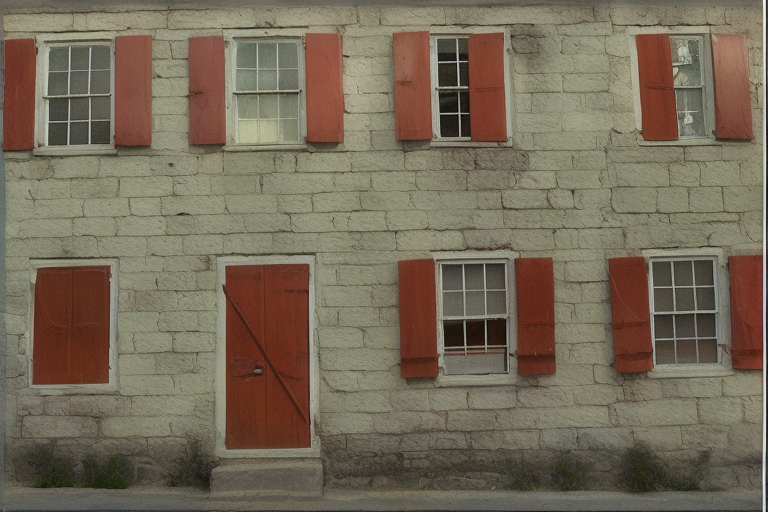

In [9]:
deblurred_image_PIL_list[0]

In [10]:
print(f"CLIP i2i score: {clipscorei2i_multiple(Images, deblurred_image_PIL_list):.4f}")

clip score: 0.7783075571060181
clip score: 0.7052441835403442
clip score: 0.7756049633026123
clip score: 0.8263632655143738
clip score: 0.7544317245483398
clip score: 0.8083792328834534
clip score: 0.8551509380340576
clip score: 0.792488694190979
clip score: 0.8493441343307495
clip score: 0.8275514841079712
clip score: 0.7631754875183105
clip score: 0.8151051998138428
clip score: 0.7829428315162659
clip score: 0.7860651016235352
clip score: 0.8945923447608948
clip score: 0.8144736289978027
clip score: 0.7666903734207153
clip score: 0.7460628151893616
clip score: 0.8042434453964233
clip score: 0.8016354441642761
clip score: 0.8450976014137268
clip score: 0.8262103796005249
clip score: 0.8892441987991333
clip score: 0.7620513439178467
CLIP i2i score: 0.8029


In [11]:
print(f"PSNR: {psnr_multiple(original_image_list, deblurred_image_list):.4f}")
print(f"LPIPS: {lpips_multiple(original_image_list, deblurred_image_list):.4f}")
print(f"Mean BPP: {mean_bpp(deblurred_images):.4f}")

pnsr: 21.07021879766579dB
pnsr: 26.546799043451923dB
pnsr: 26.896921959412943dB
pnsr: 26.299630257229122dB
pnsr: 19.56517292152259dB
pnsr: 22.17275143724107dB
pnsr: 24.552641731894145dB
pnsr: 18.686989702000186dB
pnsr: 24.306527328417744dB
pnsr: 25.448194775032373dB
pnsr: 23.227689811358037dB
pnsr: 25.279563796524158dB
pnsr: 18.921842338978795dB
pnsr: 22.427901682895165dB
pnsr: 24.39250112445545dB
pnsr: 25.0709868845941dB
pnsr: 24.581262442229917dB
pnsr: 22.113678858112735dB
pnsr: 22.314869227760102dB
pnsr: 23.525162797364754dB
pnsr: 22.609685589031262dB
pnsr: 24.33151568223138dB
pnsr: 25.356640487416012dB
pnsr: 20.628995927664437dB
PSNR: 23.3470
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
lpips: 0.2596155107021332
lpips: 0.25915324687957764
lpips: 0.20382334291934967
lpips: 0.2418976128101349
lpips: 0.2605767250061035
lpips: 0.2562192678451538
lpips: 0.16656386852264404
lpips: 0.2412286400794983
lpips: 0.22048011422157288
lpips: 0.21711380779743195
lpips: 0.24806766211986542
lpips: 0.2179926186800003
lpips: 0.4328920841217041
lpips: 0.33459264039993286
lpips: 0.19649465382099152
lpips: 0.324590265750885
lpips: 0.23670020699501038
lpips: 0.34230858087539673
lpips: 0.24263861775398254
lpips: 0.17093375325202942
lpips: 0.23009204864501953
lpips: 0.3131024241447449
lpips: 0.1448614001274109
lpips: 0.2913653254508972
LPIPS: 0.2522
Mean BPP: 0.0658
